# Convolutional Neural Network

Let's practice CNN by training the model to predict the number of coins in each image.

In [1]:
import torchvision

# Hyperparameters
seed = 2450
max_epoch = 100

In [2]:
import numpy as np
import torch

# Enforce everything is deterministic
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [3]:
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
writer = SummaryWriter()

In [4]:
# Start tensorboard web server
%tensorboard --logdir=runs --bind_all --port 8080

In [5]:
import kagglehub

path_to_dataset = kagglehub.dataset_download("balabaskar/count-coins-image-dataset")
print("Path to dataset files:", path_to_dataset)

/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1


In [6]:
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch import LightningDataModule
from lightning.pytorch import LightningModule
import lightning.pytorch as L

print(L.__version__)

%matplotlib inline
from PIL import Image

2.5.2


In [7]:
csv_path = os.path.join(path_to_dataset, 'coins_count_values.csv')
df = pd.read_csv(csv_path)
display(df[0:3])

# map image_name to coins_count
img2ct = df.set_index("image_name")["coins_count"].to_dict()

,folder,image_name,coins_count
0,all_coins,01207e3d7e.jpg,5
1,all_coins,0140acf6eb.jpg,4
2,all_coins,025c8579f0.jpg,2


In [8]:
coins_dir = os.path.join(path_to_dataset, 'coins_images/coins_images')
print(coins_dir)
path_label = []
for dirpath, _, filenames in os.walk(coins_dir):
    if len(filenames) > 0:
        folder_name = os.path.basename(dirpath)
        print(f"Found {len(filenames)} images in {folder_name}")
        for filename in filenames:
            path = (os.path.join(dirpath, filename))
            label = img2ct[filename]
            path_label += [(path, label)]

print(path_label[0:3])
print("Total # of samples:", len(path_label))

/home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images
Found 184 images in peso_coins
Found 211 images in yen_coins
Found 215 images in all_coins
Found 173 images in us_coins
Found 231 images in euro_coins
Found 220 images in indian_coins
Found 210 images in china_coins
[('/home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images/peso_coins/0c0ea30f84.jpg', 6), ('/home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images/peso_coins/61666fe63c.jpg', 5), ('/home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images/peso_coins/af48e3a674.jpg', 1)]
Total # of samples: 1444


In [9]:
def get_mean_std(path_label):
    _transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    path_list = [e[0] for e in path_label]
    R = []
    G = []
    B = []
    for path in path_list:
        img = Image.open(path).convert('RGB')
        img = _transform(img)
        # reshape from (H x W x C) to (C x H x W)
        tensor = np.moveaxis(img.numpy(), -1, 0)
        R.append(tensor[0])
        G.append(tensor[1])
        B.append(tensor[2])
    R = np.stack(R, axis=0)
    G = np.stack(G, axis=0)
    B = np.stack(B, axis=0)
    mean = np.array([np.mean(R), np.mean(G), np.mean(B)])
    std = np.array([np.std(R), np.std(G), np.std(B)])
    return mean, std


mean, std = get_mean_std(path_label)
print(f"Mean: {mean.tolist()}")
print(f"Std: {std.tolist()}")

Mean: [0.6872422099113464, 0.685499906539917, 0.6830970048904419]
Std: [0.3176698088645935, 0.3171362280845642, 0.31665119528770447]


In [10]:
from torch.utils import data


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label


class DataModule(LightningDataModule):
    def __init__(self, path_label, mean, std, batch_size=32, seed=None):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size

        if seed is None:
            self.generator = torch.default_generator
        else:
            self.generator = torch.Generator().manual_seed(seed)

        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        self.train, self.val, self.test = data.random_split(dataset, [0.8, 0.1, 0.1], self.generator)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            generator=self.generator,
            shuffle=True,
            num_workers=8,
            pin_memory=True
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val, batch_size=self.batch_size, generator=self.generator, num_workers=8)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test, batch_size=self.batch_size, generator=self.generator, num_workers=8)

    def __len__(self):
        if self.train is not None:
            return len(self.train)
        elif self.val is not None:
            return len(self.val)
        elif self.test is not None:
            return len(self.test)
        else:
            return 0


datamodule = DataModule(path_label=path_label, mean=mean, std=std, seed=seed)
datamodule.setup()

In [11]:
def upload_to_tensorboard(model: nn.Module, module: DataModule):
    sample_images, _ = next(iter(module.train_dataloader()))
    img_grid = torchvision.utils.make_grid(sample_images)
    inv_normalize = transforms.Normalize(mean=-mean / std, std=1 / std)
    img_grid = inv_normalize(img_grid)
    writer.add_images("Sample coin images", img_grid, dataformats="CHW")
    writer.add_graph(model, sample_images)
    writer.flush()

In [12]:
class CustomProgressBar(TQDMProgressBar):
    def __init__(self):
        super().__init__()

    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.disable = True
        return bar

    def on_validation_start(self, trainer, pl_module):
        pass

    def on_validation_epoch_start(self, trainer, pl_module):
        pass

    def on_validation_batch_start(self, trainer, pl_module, batch, batch_idx, dataloader_idx=0):
        pass

    def on_validation_end(self, trainer, pl_module):
        pass

    def on_validation_epoch_end(self, trainer, pl_module):
        pass

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        pass


def get_trainer():
    early_stopping = L.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, verbose=False,
        mode="min", check_on_train_epoch_end=False
    )
    tqdm_progress_bar = CustomProgressBar()
    trainer = L.Trainer(
        max_epochs=max_epoch,
        check_val_every_n_epoch=5,
        deterministic=True,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        callbacks=[early_stopping, tqdm_progress_bar],
    )
    return trainer


def save_checkpoint(trainer, model_name: str) -> str:
    ckpt_dir = "checkpoints"
    ckpt_path = os.path.join(ckpt_dir, f"{model_name}.ckpt")
    os.makedirs(ckpt_dir, exist_ok=True)
    trainer.save_checkpoint(ckpt_path)
    return ckpt_path

In [44]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def get_predict_true_pair(model) -> tuple[list, list]:
    model.eval()
    _y_true = []
    _y_pred = []
    with torch.no_grad():
        cpu_device = torch.device("cpu")
        for test_data in datamodule.test_dataloader():
            test_images, test_labels = test_data[0].to(cpu_device), test_data[1].to(cpu_device)
            pred = model(test_images)
            for i in range(len(pred)):
                if pred[i].dim() == 0:
                    pred_value = pred[i].item()
                else:
                    pred_value = torch.argmax(pred[i]).item()
                _y_pred.append(pred_value)
                _y_true.append(test_labels[i].item())
    return _y_true, _y_pred


def visualize_scatter_plot(model):
    y_true, y_pred = get_predict_true_pair(model)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Scatter Plot")
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    plt.grid(True)
    plt.show()


def visualize_test_samples(dataloader):
    images, labels = next(iter(dataloader))
    im = make_grid(images, nrow=16)

    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

    inv_normalize = transforms.Normalize(mean=-mean / std, std=1 / std)
    im = inv_normalize(im)

    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))


def visualize_confusion_matrix(model):
    y_true, y_pred = get_predict_true_pair(model)

    # Convert predictions to binary classification
    # Type I error (false positive): predicted < true
    # Type II error (false negative): predicted > true
    y_true_binary = []
    y_pred_binary = []

    for true, pred in zip(y_true, y_pred):
        pred = round(pred)
        if pred < true:
            # Type I error: predicted less than true
            y_true_binary.append(1)
            y_pred_binary.append(0)
        elif pred > true:
            # Type II error: predicted more than true
            y_true_binary.append(0)
            y_pred_binary.append(1)
        else:
            # Correct prediction
            y_true_binary.append(1)
            y_pred_binary.append(1)

    # Create confusion matrix
    cm = np.zeros((2, 2))
    for t, p in zip(y_true_binary, y_pred_binary):
        cm[t][p] += 1

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues')

    # Add numbers to cells
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f'{int(cm[i, j])}',
                     ha='center', va='center')

    plt.xticks([0, 1], ['Positive (Predicts false/less)', 'Negative (Predicts true/more)'])
    plt.yticks([0, 1], ['False (Not a coin)', 'True (Is a coin)'])
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


def visualize_prediction_heatmap(models: nn.Module | list[nn.Module], module: DataModule):
    if not isinstance(models, list):
        models = [models]
    fig, axes = plt.subplots(nrows=len(models), figsize=(12, 3 * len(models)))
    fig.suptitle('Prediction Heatmap')
    for i, model in enumerate(models):
        y_true, y_pred = get_predict_true_pair(model)
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        B = next(iter(module.test_dataloader()))[0].shape[0]  # batch size
        N = y_true.size // B  # number of batches
        rem = y_true.size % B
        if rem > 0:
            y_true = np.append(y_true, [np.full(rem, -1)])
            y_pred = np.append(y_pred, [np.full(rem, -1)])
            N += 1
        y_true = np.reshape(y_true, shape=(N, B)).astype(int)
        y_pred = np.reshape(y_pred, shape=(N, B)).astype(int)
        data = np.zeros(shape=(N, B))
        cmap = ListedColormap(['black', 'red', 'yellow', 'green'])
        for n in range(N):
            for j, (true, pred) in enumerate(zip(y_true[n], y_pred[n])):
                if true == -1:  # No data
                    data[n][j] = 0
                elif pred > true:  # False Negative
                    data[n][j] = 1
                elif pred < true:  # True Positive
                    data[n][j] = 2
                else:  # True Negative
                    data[n][j] = 3
        ax = axes[i] if len(models) > 1 else axes
        ax.pcolormesh(data, cmap=cmap)
        ax.set_title(f'{model.__class__.__name__}')
        legend_elements = [
            plt.Rectangle((0, 0), 1, 1, facecolor='black', label='No Data'),
            plt.Rectangle((0, 0), 1, 1, facecolor='red', label='False Negative (Predicts More)'),
            plt.Rectangle((0, 0), 1, 1, facecolor='yellow', label='True Positive (Predicts Less)'),
            plt.Rectangle((0, 0), 1, 1, facecolor='green', label='True Negative (Correct)')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
    plt.show()

## CNN v1

Here we have stacked multiple layers of `nn.Conv2d` and `nn.Linear` in the model.

The model learns the spatial feature of each coin in an image to produce a number.

The goal is to output a number that matches the number of coins in the image.

In [14]:
from math import sqrt


class CNNv1(LightningModule):

    def __init__(self):
        super(CNNv1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, X):
        # K: number of kernels, F: filter size, S: stride
        # I=(3,224,224)
        # K=6, F=3, S=1, O=(6,222,222)
        X = F.relu(self.conv1(X))

        # F=2, S=2, O=(6,111,111)
        X = F.max_pool2d(X, 2, 2)

        # K=16, F=3, S=1, O=(16,109,109)
        X = F.relu(self.conv2(X))

        # F=2, S=2, O=(16,54,54)
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)

        # I=(16,54,54), O=120
        X = F.relu(self.fc1(X))

        # I=120, O=84
        X = F.relu(self.fc2(X))

        # I=84, O=20
        X = F.relu(self.fc3(X))

        # I=20, O=1
        X = self.fc4(X)

        # reshape (N,1) to N, where N = batch_size
        return X.squeeze(1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = F.mse_loss(y_hat, y.float())
        self.log("train_loss", loss)
        writer.add_scalar("Loss/train", loss, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = F.mse_loss(y_hat, y.float())
        self.log("val_loss", loss)
        writer.add_scalar("Loss/val", loss, self.global_step)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        mse_loss = F.mse_loss(y_hat, y.float())
        rmse_loss = sqrt(mse_loss.item())
        self.log("mse_loss", mse_loss)  # mean squared error
        self.log("rmse_loss", rmse_loss)  # root mean squared error
        writer.add_scalar("Loss/test", mse_loss, self.global_step)


In [15]:
modelV1 = CNNv1()

In [16]:
trainer = get_trainer()
trainer.fit(modelV1, train_dataloaders=datamodule.train_dataloader(), val_dataloaders=datamodule.val_dataloader())

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | fc2   | Linear | 10.2 K | train
4 | fc3   | Linear | 1.7 K  | train
5 | fc4   | Li

/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 37/37 [00:01<00:00, 23.95it/s, v_num=0]


In [17]:
upload_to_tensorboard(modelV1, datamodule)

In [18]:
ckpt_path = save_checkpoint(trainer, f"cnn-v1-seed-{seed}")

In [19]:
modelV1 = CNNv1.load_from_checkpoint(ckpt_path)

In [20]:
trainer = get_trainer()
trainer.test(modelV1, dataloaders=datamodule.test_dataloader())
writer.flush()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 104.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        mse_loss            17.401390075683594
        rmse_loss           3.8814167976379395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1633854..1.0007952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


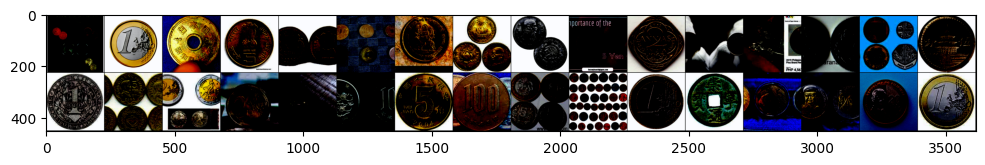

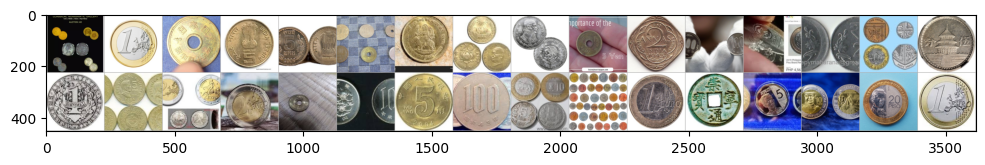

In [21]:
visualize_test_samples(datamodule.test_dataloader())

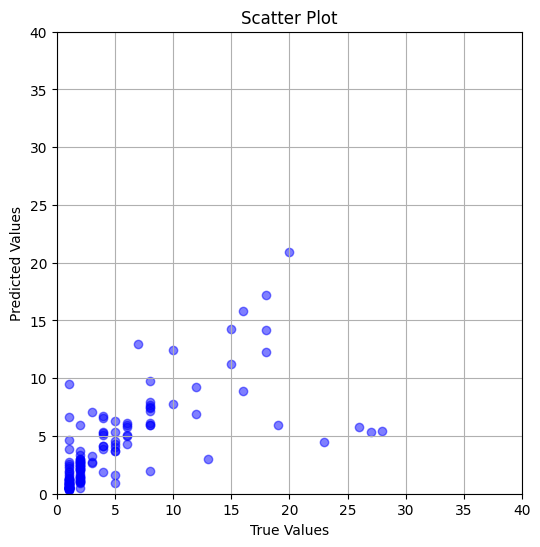

In [22]:
visualize_scatter_plot(modelV1)

## Evaluation
Feeding the same dataset is crucial to keep the experiment consistent and reliable.

We use a pseudo-random generator with arbitrary seed to keep the model's behavior consistent and deterministic for each run.

With `seed=0`, CNNv1 has $MSE = 18.8$, giving an expectation that the model would **miss ~4 coins per image** by average.

One might argue that it's unfair to judge the model this way because the number of coins varies greatly across the images.

However, it's clearly obvious in the plot above that the model is overfitted to some degree.

## CNN v2

- One more layer of receptive field
- Introduce batch normalization
- Introduce dropout regularization during affine transformation

In [23]:
from math import sqrt


class CNNv2(LightningModule):

    def __init__(self, dropout=0.2):
        super(CNNv2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)

        self.fc1 = nn.Linear(in_features=32 * 28 * 28, out_features=128)
        self.dropout1 = nn.Dropout(p=dropout)

        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.dropout2 = nn.Dropout(p=dropout)

        self.fc3 = nn.Linear(in_features=64, out_features=8)
        self.dropout3 = nn.Dropout(p=dropout)

        self.fc4 = nn.Linear(in_features=8, out_features=1)

    def forward(self, X):
        # B x 3 x 224 x 224
        X = self.conv1(X)
        X = F.relu(self.bn1(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 8 x 112 x 112
        X = self.conv2(X)
        X = F.relu(self.bn2(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 16 x 56 x 56
        X = self.conv3(X)
        X = F.relu(self.bn3(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 32 x 28 x 28
        X = X.view(-1, 32 * 28 * 28)
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)

        # B x 128
        X = F.relu(self.fc2(X))
        X = self.dropout2(X)

        # B x 64
        X = F.relu(self.fc3(X))
        X = self.dropout3(X)

        # B x 8
        X = F.relu(self.fc4(X))

        # B x 1
        return X.squeeze(1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = F.mse_loss(y_hat, y.float())
        self.log("train_loss", loss)
        writer.add_scalar("Loss/train", loss, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = F.mse_loss(y_hat, y.float())
        self.log("val_loss", loss)
        writer.add_scalar("Loss/val", loss, self.global_step)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        mse_loss = F.mse_loss(y_hat, y.float())
        rmse_loss = sqrt(mse_loss.item())
        self.log("mse_loss", mse_loss, on_epoch=True, on_step=False)
        self.log("rmse_loss", rmse_loss, on_epoch=True, on_step=False)
        writer.add_scalar("Loss/test", mse_loss, self.global_step)

In [24]:
modelV2 = CNNv2()

### Important note
Don't pass `DataModule` to `Trainer.fit()`. Otherwise, testing becomes unreliable as the dataset for testing will change after each run.

In [25]:
trainer = get_trainer()
trainer.fit(modelV2, train_dataloaders=datamodule.train_dataloader(), val_dataloaders=datamodule.val_dataloader())
writer.flush()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type        | Params | Mode 
--------------------------------------------------
0  | conv1    | Conv2d      | 224    | train
1  | bn1      | BatchNorm2d | 16     | train
2  | conv2    | Conv2d      | 1.2 K  | train
3  | bn2      | BatchNorm2d | 32     | train
4  | conv3    | Conv2d      | 4.6 K  | train
5  | bn3      | BatchNorm2d | 64     | train
6  | fc1      | Linear      | 3.2 M  | train
7  | dropout1 | Dropout     | 0      | train
8  | fc2      | Linear      | 8.3 K  | train
9  | dropout2 | Dropout     | 0      | train
10 | fc3      | Linear      | 520    | train
11 | dropout3 | Dropout     | 0      | train


/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 37/37 [00:01<00:00, 26.55it/s, v_num=2]


In [48]:
upload_to_tensorboard(modelV2, datamodule)

In [26]:
ckpt_path = save_checkpoint(trainer, f"cnn-v2-seed-{seed}")

In [27]:
modelV2 = CNNv2.load_from_checkpoint(f"checkpoints/cnn-v2-seed-{seed}.ckpt")

In [28]:
trainer = get_trainer()
trainer.test(model=modelV2, dataloaders=datamodule.test_dataloader())
writer.flush()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 160.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        mse_loss             16.75823211669922
        rmse_loss           3.8981404304504395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


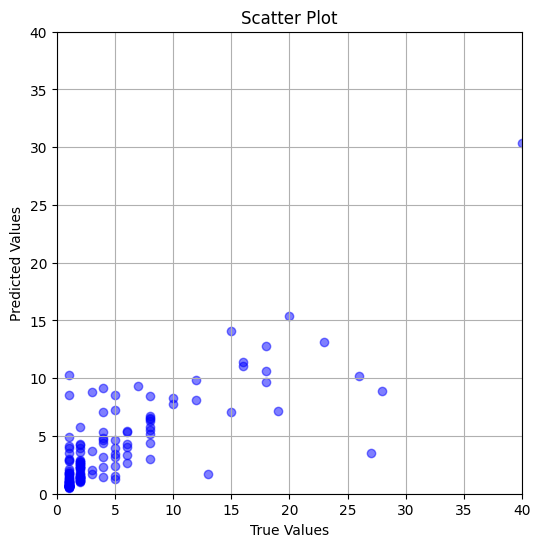

In [29]:
visualize_scatter_plot(modelV2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1633854..1.0007952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


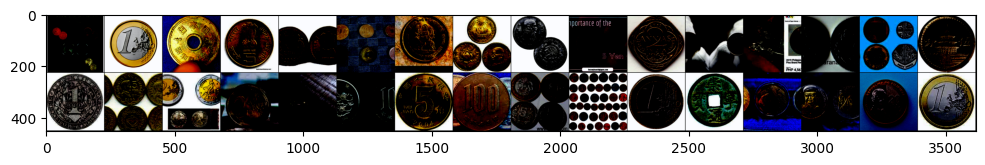

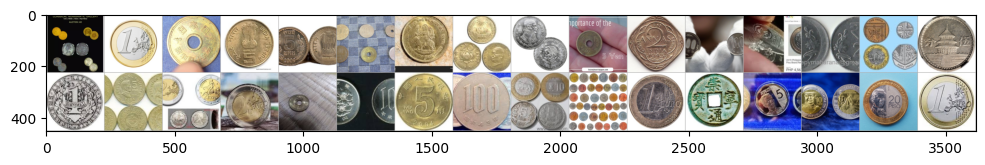

In [30]:
visualize_test_samples(datamodule.test_dataloader())

## Precision issue

Let's visualize the model's precision with confusion matrix.

Unlike the MSE and scatter plot, we can spot the model is lacking the precision by a fraction.

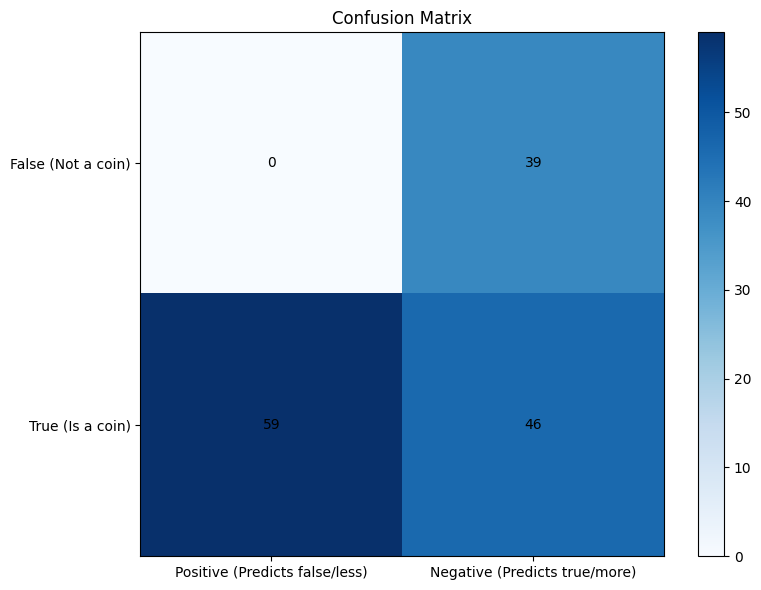

In [31]:
visualize_confusion_matrix(modelV2)

This is because the model is producing a floating point number $N \in \mathbb{R}$ but the integers are sparse in this space.

And we don't want the model to produce ambiguous numbers like 3.95 or 1.002.

In [32]:
y_true, y_pred = get_predict_true_pair(modelV2)
print("y_true:", y_true)
print("y_pred:", y_pred)

y_true: [10, 1, 1, 1, 2, 6, 1, 3, 2, 1, 1, 2, 1, 2, 8, 1, 1, 6, 4, 2, 1, 2, 1, 3, 4, 40, 1, 1, 3, 2, 1, 1, 15, 1, 2, 27, 1, 1, 2, 2, 2, 8, 1, 2, 19, 3, 1, 2, 1, 2, 2, 18, 2, 16, 2, 16, 1, 5, 6, 5, 5, 1, 1, 2, 8, 1, 4, 12, 8, 15, 8, 2, 4, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 4, 1, 8, 23, 10, 2, 5, 1, 8, 5, 2, 1, 28, 20, 1, 2, 4, 2, 1, 1, 2, 2, 4, 6, 12, 5, 1, 13, 1, 1, 2, 4, 6, 5, 1, 7, 2, 1, 5, 8, 1, 8, 26, 1, 1, 18, 1, 1, 1, 1, 6, 18, 2, 1, 1, 4, 2, 8, 5, 1]
y_pred: [8.257468223571777, 0.9671259522438049, 1.3155611753463745, 1.9461636543273926, 1.7517955303192139, 2.619640350341797, 1.8017258644104004, 3.7411346435546875, 2.6013996601104736, 4.909853458404541, 1.1183104515075684, 3.600707530975342, 10.282027244567871, 2.8427484035491943, 2.991403818130493, 0.6917186975479126, 1.1663150787353516, 4.309549331665039, 4.645300388336182, 1.0974892377853394, 2.9337806701660156, 1.5205273628234863, 0.6612268090248108, 1.7233431339263916, 7.051244258880615, 30.39945411682129, 0.7488167881965637, 

## CNN v3
- To fix this, we modify the last layer of CNN to produce `N=31` tuples of vector. It will count from 0 to 30.
- Next, we replace the final regression layer with a softmax layer.
- During test, use `torch.argmax()` before comparing with ground truth.
- Bonus: let's make Conv2d layers much deeper to expand the receptive field.

In [33]:
from math import sqrt


class CNNv3(LightningModule):
    max_count: int

    def __init__(self, dropout=0.2, max_count=36):
        super(CNNv3, self).__init__()

        self.max_count = max_count

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)

        self.conv10 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=512)

        self.fc1 = nn.Linear(in_features=256 * 14 * 14, out_features=256)
        self.dropout1 = nn.Dropout(p=dropout)

        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.dropout2 = nn.Dropout(p=dropout)

        self.fc3 = nn.Linear(in_features=128, out_features=self.max_count + 1)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, X):
        # B x 3 x 224 x 224
        X = self.conv1(X)
        X = self.conv2(X)
        X = F.relu(self.bn1(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 32 x 112 x 112
        X = self.conv3(X)
        X = self.conv4(X)
        X = F.relu(self.bn2(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 64 x 56 x 56
        X = self.conv5(X)
        X = self.conv6(X)
        X = F.relu(self.bn3(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 128 x 28 x 28
        X = self.conv7(X)
        X = self.conv8(X)
        X = self.conv9(X)
        X = F.relu(self.bn4(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 256 x 14 x 14
        X = X.view(-1, 256 * 14 * 14)
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)

        # B x 256
        X = F.relu(self.fc2(X))
        X = self.dropout2(X)

        # B x 128
        X = F.relu(self.fc3(X))

        # B x (max_class)
        return X

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        y = torch.clamp(y, min=0, max=self.max_count)
        y = F.one_hot(y, num_classes=self.max_count + 1).to(y_hat.dtype)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        writer.add_scalar("Loss/train", loss, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        y = torch.clamp(y, min=0, max=self.max_count)
        y = F.one_hot(y, num_classes=self.max_count + 1).to(y_hat.dtype)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss)
        writer.add_scalar("Loss/val", loss, self.global_step)
        return loss

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        y_onehot = F.one_hot(torch.clamp(y, min=0, max=self.max_count), num_classes=self.max_count + 1).to(y_hat.dtype)
        loss = self.loss(y_hat, y_onehot)
        mse_loss = F.mse_loss(torch.argmax(y_hat, dim=1).float(), y.float())
        rmse_loss = sqrt(mse_loss.item())
        self.log("cross_entropy_loss", loss)
        self.log("mse_loss", mse_loss, on_epoch=True, on_step=False)
        self.log("rmse_loss", rmse_loss, on_epoch=True, on_step=False)
        writer.add_scalar("Loss/test", loss, self.global_step)
        return loss

In [34]:
modelV3 = CNNv3()
trainer = get_trainer()
trainer.fit(modelV3, train_dataloaders=datamodule.train_dataloader(), val_dataloaders=datamodule.val_dataloader())
writer.flush()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params | Mode 
-------------------------------------------------------
0  | conv1    | Conv2d           | 896    | train
1  | conv2    | Conv2d           | 9.2 K  | train
2  | bn1      | BatchNorm2d      | 64     | train
3  | conv3    | Conv2d           | 18.5 K | train
4  | conv4    | Conv2d           | 36.9 K | train
5  | bn2      | BatchNorm2d      | 128    | train
6  | conv5    | Conv2d           | 73.9 K | train
7  | conv6    | Conv2d           | 147 K  | train
8  | bn3      | BatchNorm2d      | 256    | train
9  | conv7    | Conv2d           | 295 K  | train
10 | conv8    | Conv2d        

/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 69: 100%|██████████| 37/37 [00:01<00:00, 20.85it/s, v_num=4]


In [49]:
upload_to_tensorboard(modelV3, datamodule)

In [35]:
ckpt_path = save_checkpoint(trainer, f"cnn-v3-seed-{seed}")

In [36]:
modelV3 = CNNv3.load_from_checkpoint(f"checkpoints/cnn-v3-seed-{seed}.ckpt")
trainer = get_trainer()
trainer.test(modelV3, dataloaders=datamodule.test_dataloader())
writer.flush()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 65.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   cross_entropy_loss       1.6105575561523438
        mse_loss             24.47222137451172
        rmse_loss            4.829188346862793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


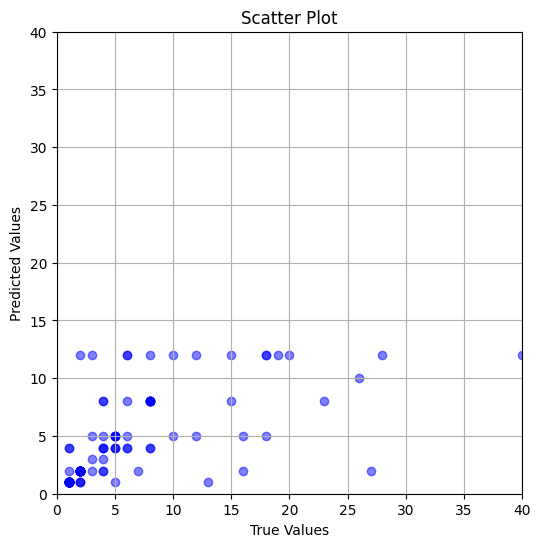

In [37]:
visualize_scatter_plot(modelV3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1633854..1.0007952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


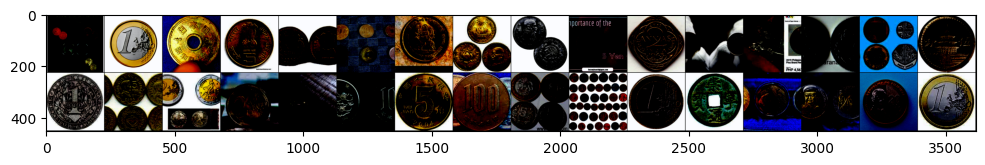

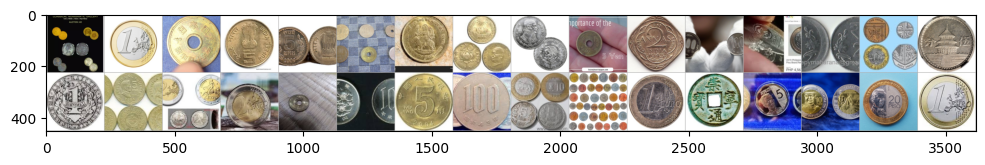

In [38]:
visualize_test_samples(datamodule.test_dataloader())

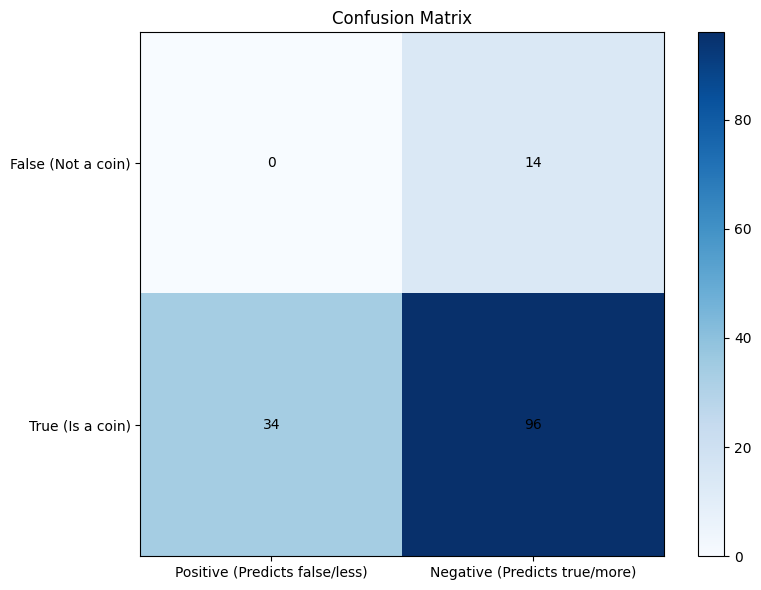

In [39]:
visualize_confusion_matrix(modelV3)

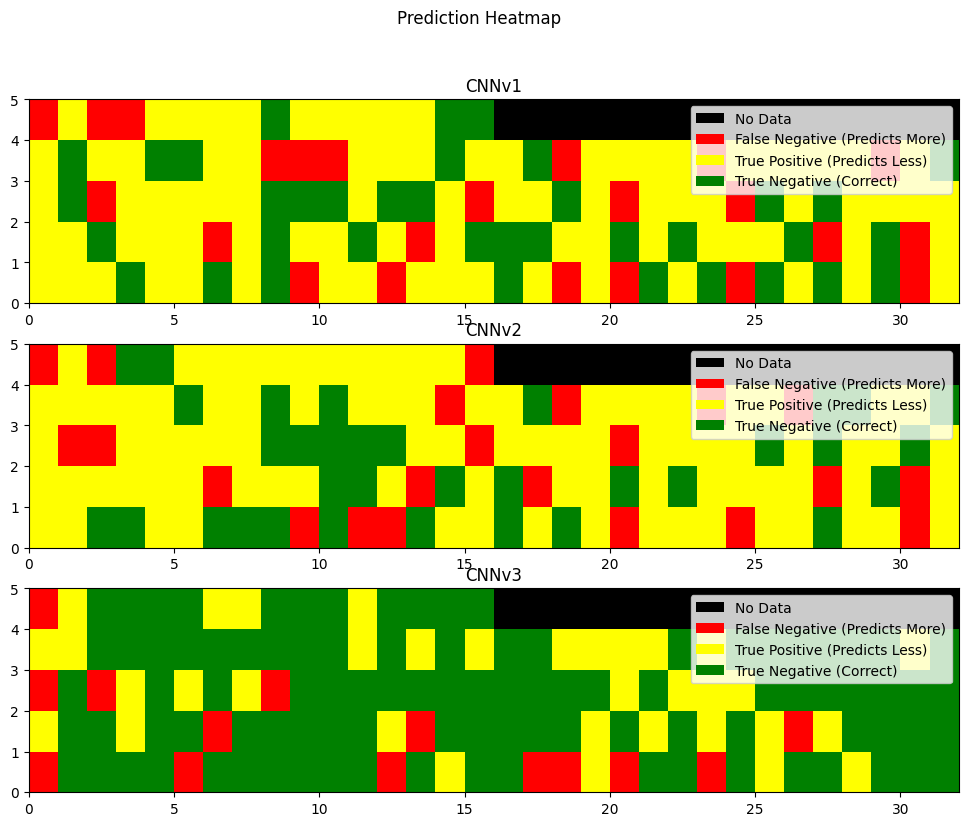

In [47]:
visualize_prediction_heatmap([modelV1, modelV2, modelV3], datamodule)

## Experiments

| model | seed | mse_loss | rmse_loss | cross_entropy |
|-------|------|----------|-----------|---------------|
| v1    | 0    | 11.63    | 3.23      | N/A           |
| v2    | 0    | 11.32    | 3.23      | N/A           |
| v3    | 0    | 17.75    | 4.15      | 1.29          |
| v1    | 4    | 6.33     | 4.78      | N/A           |
| v2    | 4    | 6.67     | 2.56      | N/A           |
| v3    | 4    | 9.38     | 2.90      | 1.72          |
| v1    | 99   | 9.01     | 2.82      | N/A           |
| v2    | 99   | 13.13    | 3.61      | N/A           |
| v3    | 99   | 27.64    | 5.08      | 1.78          |
| v1    | 2450 | 17.40    | 3.88      | N/A           |
| v2    | 2450 | 16.80    | 3.93      | N/A           |
| v3    | 2450 | 26.02    | 4.93      | 1.18          |